In [0]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import os

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.activations import relu,tanh

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/sih/'

In [124]:
df=pd.read_csv(BASE_DIR+'train_FD003.txt', sep=" ", header=None,names=['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21','a','b'])
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,a,b
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,NaN,NaN
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,NaN,NaN
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,NaN,NaN
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,NaN,NaN
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,NaN,NaN


In [0]:
col=['a','b']
df.drop(col,inplace=True,axis=1)

In [126]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


medium working time: 247.2
max working time: 525
min working time: 145


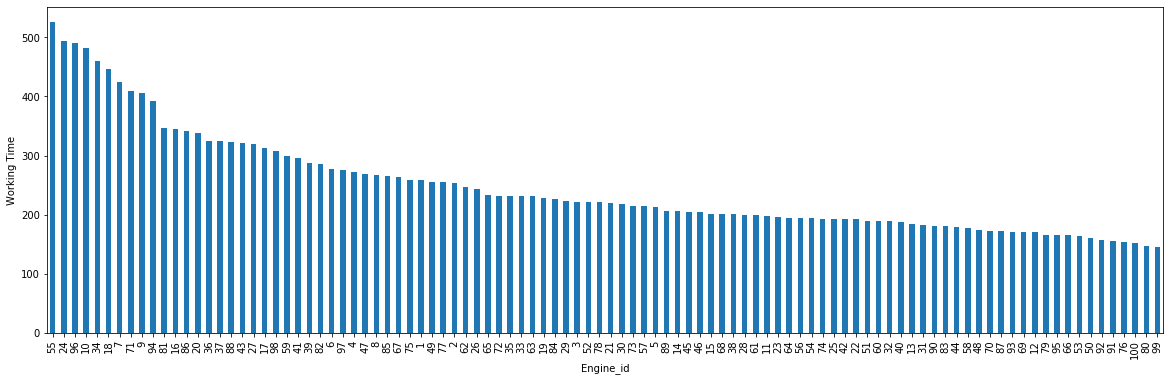

In [127]:
#calculating the median, max and mean working time 
#below is the plot of working time of different engine
plt.figure(figsize=(20,6))
plt.xlabel('Engine_id')
plt.ylabel('Working Time')
df.id.value_counts().plot.bar()
print("medium working time:", df.id.value_counts().mean())
print("max working time:", df.id.value_counts().max())
print("min working time:", df.id.value_counts().min())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f42ae6d3b00>,
      dtype=object)

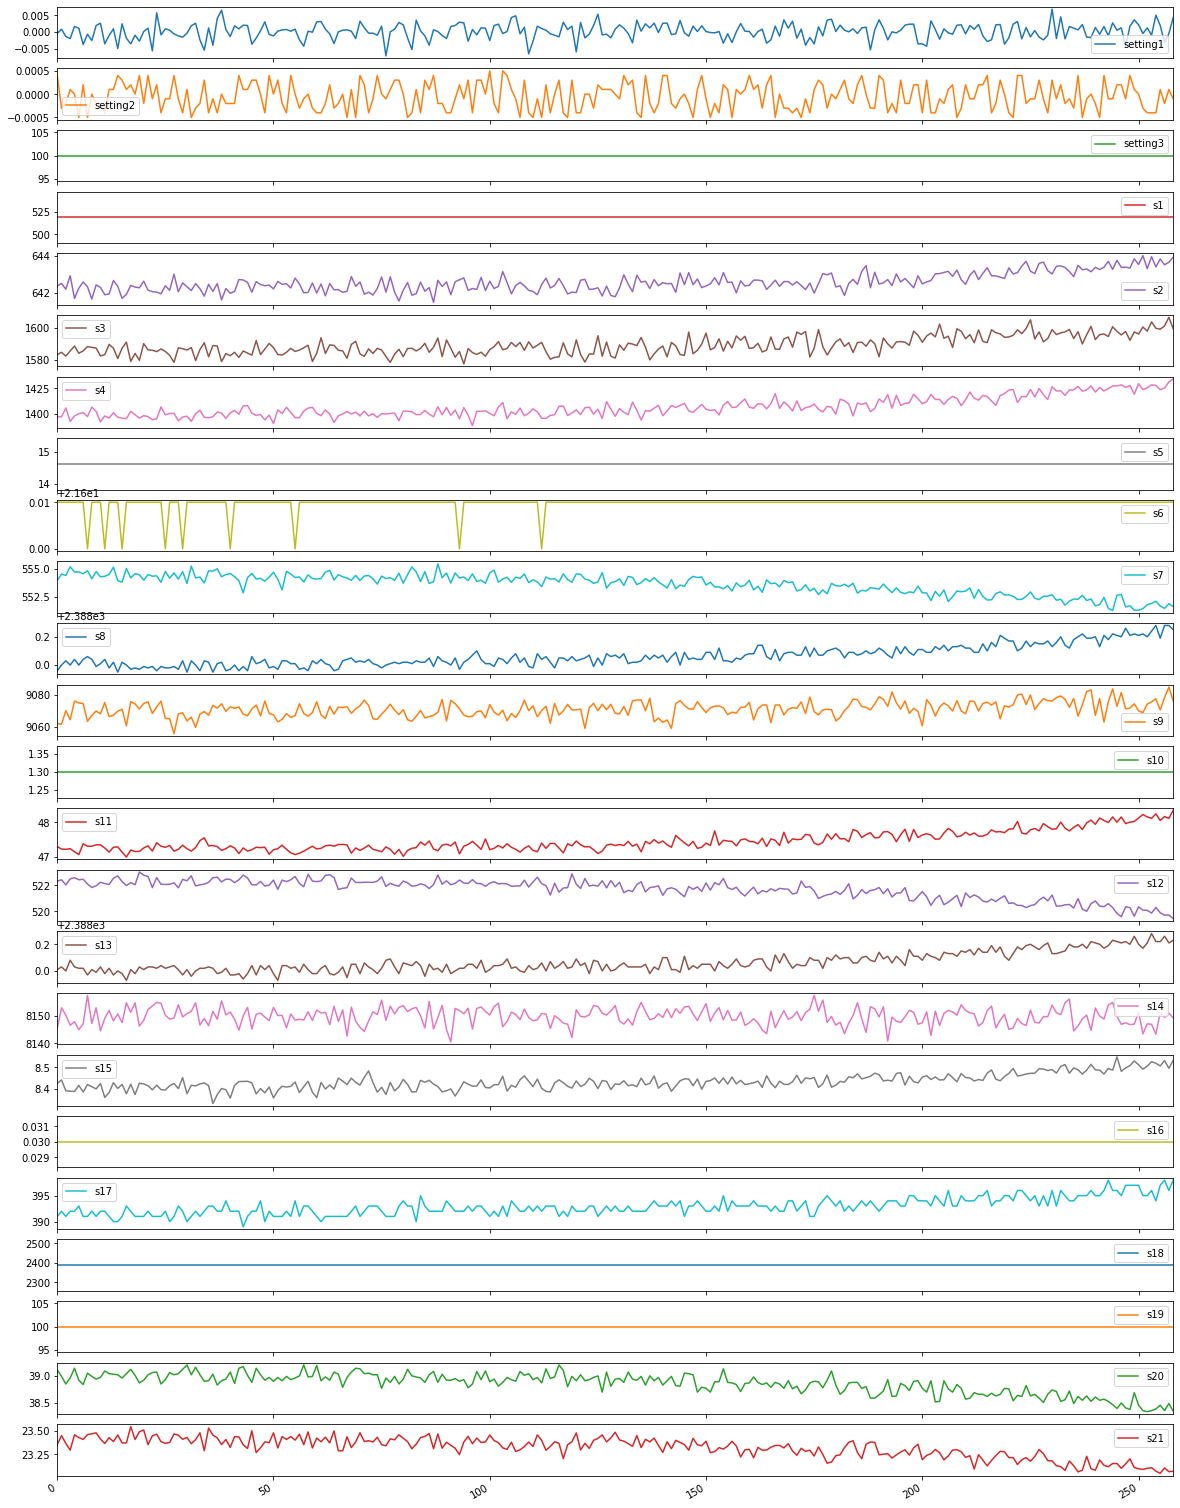

In [128]:
#plotting different sensor data  for a engine id
engine_id=df[df['id']==1]1.0
engine_id[df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

In [129]:
df1=pd.read_csv(BASE_DIR+'test_FD003.txt', sep=" ", header=None,names=['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21','a','b'])
col=['a','b']
df1.drop(col,inplace=True,axis=1)
df1.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,21.58,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,21.58,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,21.58,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,21.59,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,21.58,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950


In [130]:
df['RUL']=df.groupby(['id'])['cycle'].transform(max)-df['cycle']
df.RUL[0:10]

0    258
1    257
2    256
3    255
4    254
5    253
6    252
7    251
8    250
9    249
Name: RUL, dtype: int64

In [0]:
### ADD NEW LABEL TRAIN ###
w1 = 45
w0 = 15
df['label1'] = np.where(df['RUL'] <= w1, 1, 0 )
df['label2'] = df['label1']
df.loc[df['RUL'] <= w0, 'label2'] = 2

In [0]:
#scaling the data
def scale(df):
    return (df - df.min())/(df.max()-df.min())

for col in df.columns:
    if col[0] == 's':
        df[col] = scale(df[col])

In [172]:
df = df.dropna(axis=1)
df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.470930,0.769231,0.355972,0.370523,0.308580,1.0,0.208812,0.623529,0.204233,0.333333,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331,258,0,0
1,1,2,0.546512,0.230769,0.388759,0.399100,0.309360,1.0,0.236590,0.647059,0.202431,0.333333,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836,257,0,0
2,1,3,0.418605,0.307692,0.313817,0.353298,0.445398,1.0,0.230843,0.664706,0.241484,0.333333,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577,256,0,0
3,1,4,0.383721,0.538462,0.487119,0.417107,0.237285,1.0,0.268199,0.647059,0.215326,0.333333,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966,255,0,0
4,1,5,0.593023,0.461538,0.196721,0.476218,0.321217,1.0,0.245690,0.670588,0.268799,0.333333,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371,254,0,0


In [173]:
### LOAD GROUND TRUTH ###
truth_df = pd.read_csv(BASE_DIR+'RUL_FD003.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,44
2,51
3,27


In [0]:
### CALCULATE RUL TEST ###
truth_df['max'] = df1.groupby('id')['cycle'].max() + truth_df['more']
df1['RUL'] = [truth_df['max'][i] for i in df1.id] - df1['cycle']

In [0]:
### ADD NEW LABEL TEST ###
df1['label1'] = np.where(df1['RUL'] <= w1, 1, 0 )
df1['label2'] = df1['label1']
df1.loc[df1['RUL'] <= w0, 'label2'] = 2

In [176]:
### SCALE TEST DATA ###

for col in df1.columns:
    if col[0] == 's':
        df1[col] = scale(df1[col])
#     elif col == 'cycle':
#         test_df['cycle_norm'] = scale(test_df[col])
        
df1 =df1.dropna(axis=1)
df1.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.411765,0.166667,0.330128,0.400713,0.345269,0.500000,0.276338,0.636943,0.265810,0.5,0.27500,0.234967,0.628931,0.326196,0.531661,0.363636,0.524476,0.503084,276,0,0
1,1,2,0.547059,0.333333,0.355769,0.470392,0.384025,0.500000,0.250965,0.643312,0.243832,0.5,0.26875,0.232739,0.672956,0.372280,0.621864,0.363636,0.503497,0.544905,275,0,0
2,1,3,0.594118,0.250000,0.246795,0.397146,0.246705,0.500000,0.268064,0.662420,0.330811,0.5,0.31250,0.246659,0.628931,0.381706,0.469833,0.363636,0.545455,0.475450,274,0,0
3,1,4,0.670588,0.583333,0.413462,0.462545,0.313988,0.666667,0.277441,0.643312,0.332055,0.5,0.38125,0.266147,0.641509,0.367974,0.516428,0.454545,0.454545,0.541821,273,0,0
4,1,5,0.505882,0.583333,0.496795,0.569560,0.324218,0.500000,0.254275,0.687898,0.265188,0.5,0.18125,0.236080,0.647799,0.334575,0.646953,0.363636,0.538462,0.439181,272,0,0


In [0]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [178]:
sequence_cols = []
for col in df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [179]:
x_train, x_test = [], []
for engine_id in df.id.unique():
    for sequence in gen_sequence(df[df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(df1[df1.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
   
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (19720, 50, 18)
X_Test shape: (11620, 50, 18)


In [180]:
### GENERATE Y TRAIN TEST ###
y_train, y_test = [], []
for engine_id in df.id.unique():
    for label in gen_labels(df[df.id==engine_id], sequence_length, ['label2'] ):
        y_train.append(label)
    for label in gen_labels(df1[df1.id==engine_id], sequence_length, ['label2']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (19720, 1)
y_test shape: (11620, 1)


In [181]:
### ENCODE LABEL ###
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(19720, 3)
(11620, 3)


In [0]:
def rec_plot(s, eps=0.10, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

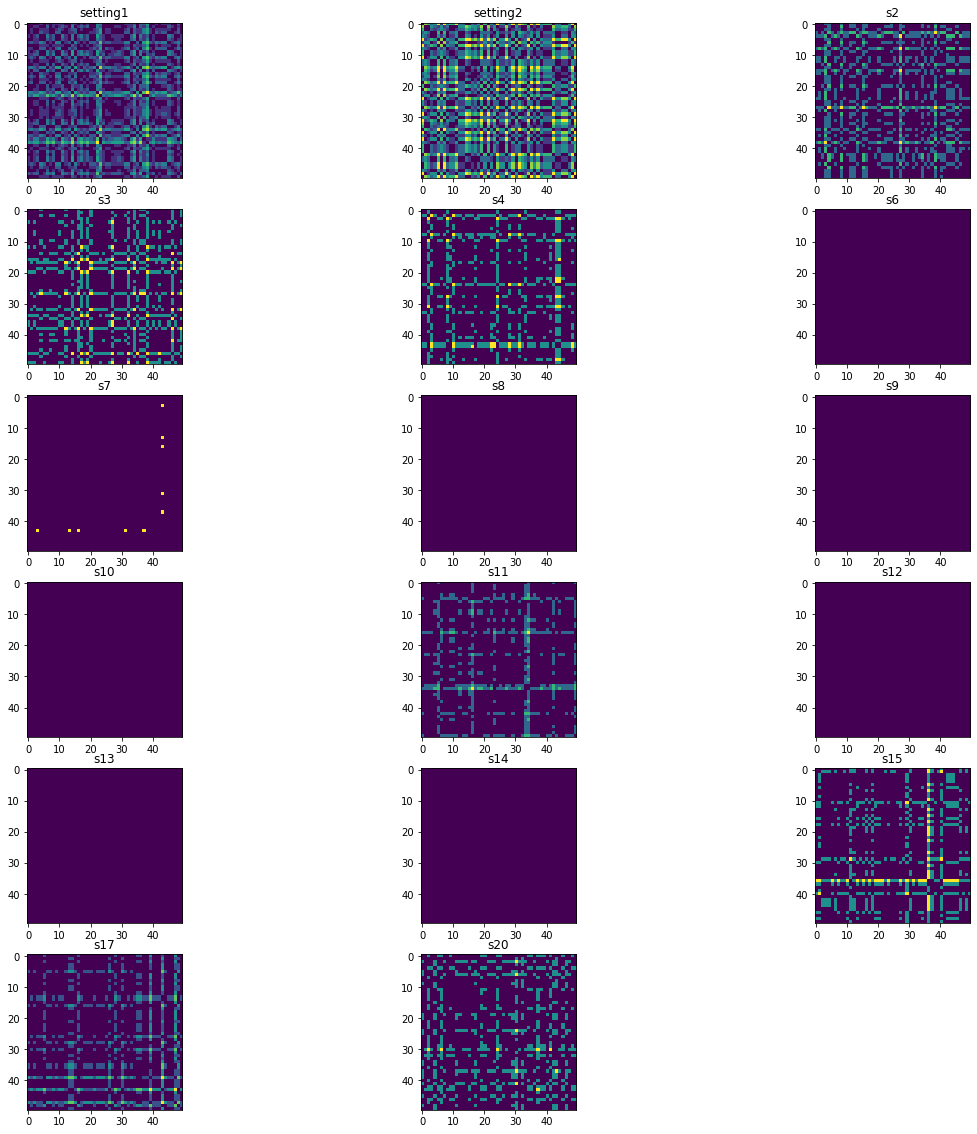

In [183]:
plt.figure(figsize=(20,20))
for i in range(0,17):
    
    plt.subplot(6, 3, i+1)    
    rec = rec_plot(x_train[0,:,i])
    plt.imshow(rec)
    plt.title(sequence_cols[i])
plt.show()

In [184]:
### TRANSFORM X TRAIN TEST IN IMAGES ###
x_train_img = np.apply_along_axis(rec_plot, 1, x_train).astype('float16')
print(x_train_img.shape)

x_test_img = np.apply_along_axis(rec_plot, 1, x_test).astype('float16')
print(x_test_img.shape)

(19720, 50, 50, 18)
(11620, 50, 50, 18)


In [185]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 18)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 48, 48, 32)        5216      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 64)         

In [186]:
es = EarlyStopping(monitor='val_acc', mode='auto', restore_best_weights=True, verbose=1, patience=6)

model.fit(x_train_img, y_train, batch_size=512, epochs=25, callbacks=[es],
          validation_split=0.2, verbose=1)

Train on 15776 samples, validate on 3944 samples
Epoch 1/25
15776/15776 [==============================] - 8s 531us/sample - loss: 0.8215 - acc: 0.7499 - val_loss: 0.6400 - val_acc: 0.7660
Epoch 2/25
15776/15776 [==============================] - 8s 499us/sample - loss: 0.4569 - acc: 0.8017 - val_loss: 0.2679 - val_acc: 0.8986
Epoch 3/25
15776/15776 [==============================] - 8s 504us/sample - loss: 0.2733 - acc: 0.8934 - val_loss: 0.2197 - val_acc: 0.9118
Epoch 4/25
15776/15776 [==============================] - 8s 493us/sample - loss: 0.2251 - acc: 0.9099 - val_loss: 0.2115 - val_acc: 0.9227
Epoch 5/25
15776/15776 [==============================] - 8s 497us/sample - loss: 0.2140 - acc: 0.9134 - val_loss: 0.2095 - val_acc: 0.9194
Epoch 6/25
15776/15776 [==============================] - 8s 500us/sample - loss: 0.1915 - acc: 0.9253 - val_loss: 0.1942 - val_acc: 0.9196
Epoch 7/25
15776/15776 [==============================] - 8s 498us/sample - loss: 0.1747 - acc: 0.9310 - val_lo

In [187]:
model.evaluate(x_test_img, y_test, verbose=2)

11620/11620 - 5s - loss: 0.8123 - acc: 0.8090


[0.8122592066386507, 0.80903614]

In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [189]:
print(classification_report(np.where(y_test != 0)[1], model.predict_classes(x_test_img)))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90     10983
           1       0.17      0.70      0.27       576
           2       0.27      0.92      0.42        61

    accuracy                           0.81     11620
   macro avg       0.48      0.81      0.53     11620
weighted avg       0.95      0.81      0.86     11620



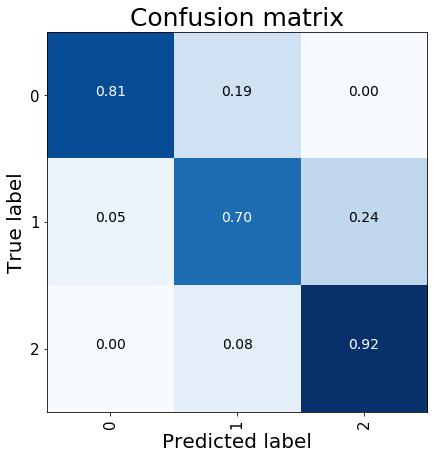

In [190]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()



***

